In [ ]:
!pip install numpy==2.2.3 pandas==2.2.3 scikit-learn==1.6.1 matplotlib==3.10.1 seaborn==0.13.2 hmmlearn==0.3.3 pgmpy==0.1.26 medmnist==3.0.2

In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from medmnist import PneumoniaMNIST, INFO

In [2]:
# Load dataset
def load_pneumonia_data(download=True):
    """Load PneumoniaMNIST dataset"""
    print("Loading PneumoniaMNIST dataset...")
    
    # Print dataset info
    dataset_info = INFO['pneumoniamnist']
    print(f"Dataset description: {dataset_info['description']}")
    print(f"Number of classes: {len(dataset_info['label'])}, Labels: {dataset_info['label']}")
    
    # Load train and test datasets
    train_dataset = PneumoniaMNIST(split='train', download=download)
    test_dataset = PneumoniaMNIST(split='test', download=download)
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    return train_dataset, test_dataset

# Load data
train_dataset, test_dataset = load_pneumonia_data()

Loading PneumoniaMNIST dataset...
Dataset description: The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.
Number of classes: 2, Labels: {'0': 'normal', '1': 'pneumonia'}
Training samples: 4708
Test samples: 624


In [3]:
# Preprocess data cho SVM
def preprocess_data(train_dataset, test_dataset):
    """Preprocess data for SVM training"""
    print("Preprocessing data for SVM...")
    
    # Convert to float and normalize
    x_train = train_dataset.imgs.astype('float32') / 255.0
    y_train = train_dataset.labels.flatten()
    
    x_test = test_dataset.imgs.astype('float32') / 255.0
    y_test = test_dataset.labels.flatten()
    
    # Flatten images for SVM (SVM cần input là vector 1D)
    x_train_flat = x_train.reshape(x_train.shape[0], -1)
    x_test_flat = x_test.reshape(x_test.shape[0], -1)
    
    print(f"Training data shape: {x_train_flat.shape}")
    print(f"Test data shape: {x_test_flat.shape}")
    print(f"Number of classes: {len(np.unique(y_train))}")
    print(f"Class distribution in training: {np.bincount(y_train)}")
    
    return x_train_flat, y_train, x_test_flat, y_test

# Preprocess data
x_train, y_train, x_test, y_test = preprocess_data(train_dataset, test_dataset)

Preprocessing data for SVM...
Training data shape: (4708, 784)
Test data shape: (624, 784)
Number of classes: 2
Class distribution in training: [1214 3494]


Sample images from training dataset:


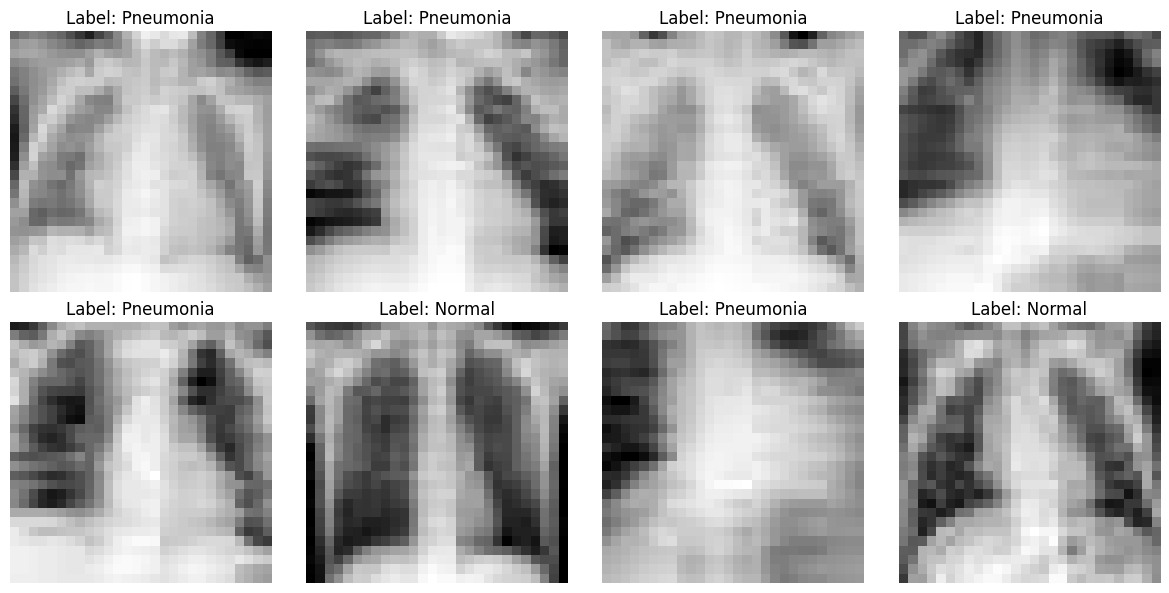

In [4]:
# Visualize một số sample data
def visualize_samples(dataset, num_samples=8):
    """Visualize sample images from dataset"""
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(num_samples):
        img = dataset.imgs[i].squeeze()
        label = dataset.labels[i].item()
        label_name = 'Normal' if label == 0 else 'Pneumonia'
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {label_name}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Sample images from training dataset:")
visualize_samples(train_dataset)

In [5]:
# Subsample data nếu cần (SVM có thể chậm với dataset lớn)
def subsample_data(x_train, y_train, x_test, y_test, max_train=5000, max_test=2000):
    """Subsample data for faster training (optional)"""
    
    # Subsample training data nếu quá lớn
    if len(x_train) > max_train:
        print(f"Subsampling training data: {len(x_train)} -> {max_train}")
        idx = np.random.choice(len(x_train), max_train, replace=False)
        x_train_sub = x_train[idx]
        y_train_sub = y_train[idx]
    else:
        x_train_sub = x_train
        y_train_sub = y_train
    
    # Subsample test data nếu quá lớn
    if len(x_test) > max_test:
        print(f"Subsampling test data: {len(x_test)} -> {max_test}")
        x_test_sub = x_test[:max_test]
        y_test_sub = y_test[:max_test]
    else:
        x_test_sub = x_test
        y_test_sub = y_test
    
    print(f"Final training samples: {len(x_train_sub)}")
    print(f"Final test samples: {len(x_test_sub)}")
    
    return x_train_sub, y_train_sub, x_test_sub, y_test_sub

# Subsample data để training nhanh hơn
x_train_final, y_train_final, x_test_final, y_test_final = subsample_data(
    x_train, y_train, x_test, y_test
)

Final training samples: 4708
Final test samples: 624


In [6]:
# Train SVM model
def train_svm(x_train, y_train, kernel='rbf', C=1.0, gamma='scale'):
    """Train SVM model"""
    print(f"\nTraining SVM with parameters:")
    print(f"  Kernel: {kernel}")
    print(f"  C: {C}")
    print(f"  Gamma: {gamma}")
    
    # Initialize SVM model
    model = SVC(kernel=kernel, C=C, gamma=gamma, probability=True, random_state=42)
    
    # Train model
    print("\nStarting training...")
    start_time = time.time()
    
    model.fit(x_train, y_train)
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    return model

# Train SVM model
svm_model = train_svm(x_train_final, y_train_final)


Training SVM with parameters:
  Kernel: rbf
  C: 1.0
  Gamma: scale

Starting training...
Training completed in 7.91 seconds


In [7]:
# Evaluate model
def evaluate_model(model, x_test, y_test):
    """Evaluate trained model"""
    print("\nEvaluating model on test data...")
    
    # Make predictions
    start_time = time.time()
    predictions = model.predict(x_test)
    inference_time = time.time() - start_time
    
    print(f"Inference completed in {inference_time:.2f} seconds for {len(x_test)} samples")
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    print(f"\nTest Accuracy: {accuracy:.4f}")
    
    return predictions, accuracy

# Evaluate model
predictions, accuracy = evaluate_model(svm_model, x_test_final, y_test_final)


Evaluating model on test data...
Inference completed in 0.14 seconds for 624 samples

Test Accuracy: 0.8542


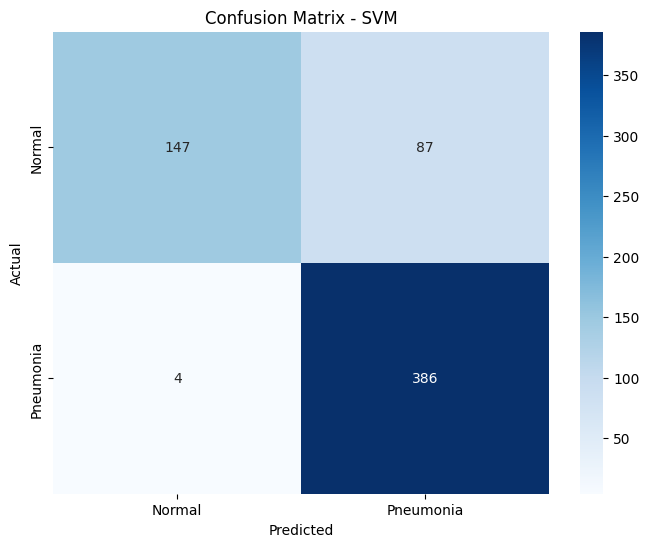


Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.63      0.76       234
   Pneumonia       0.82      0.99      0.89       390

    accuracy                           0.85       624
   macro avg       0.89      0.81      0.83       624
weighted avg       0.88      0.85      0.85       624



In [8]:
# Visualize results
def visualize_results(y_true, y_pred):
    """Visualize model performance"""
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - SVM')
    plt.show()
    
    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, 
                                target_names=['Normal', 'Pneumonia']))

# Visualize results
visualize_results(y_test_final, predictions)

In [9]:
# Analyze model performance
def analyze_performance(model, x_test, y_test, predictions):
    """Analyze detailed model performance"""
    print("\n" + "="*50)
    print("SVM MODEL PERFORMANCE ANALYSIS")
    print("="*50)
    
    # Basic metrics
    accuracy = accuracy_score(y_test, predictions)
    
    # Per-class accuracy
    cm = confusion_matrix(y_test, predictions)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Normal Class Accuracy: {class_accuracies[0]:.4f}")
    print(f"Pneumonia Class Accuracy: {class_accuracies[1]:.4f}")
    
    # Model info
    print(f"\nModel Information:")
    print(f"  Number of support vectors: {model.n_support_}")
    print(f"  Total support vectors: {sum(model.n_support_)}")
    print(f"  Support vector ratio: {sum(model.n_support_) / len(x_test):.4f}")
    
    return {
        'accuracy': accuracy,
        'normal_accuracy': class_accuracies[0],
        'pneumonia_accuracy': class_accuracies[1],
        'n_support_vectors': sum(model.n_support_)
    }

# Analyze performance
performance_metrics = analyze_performance(svm_model, x_test_final, y_test_final, predictions)


SVM MODEL PERFORMANCE ANALYSIS
Overall Accuracy: 0.8542
Normal Class Accuracy: 0.6282
Pneumonia Class Accuracy: 0.9897

Model Information:
  Number of support vectors: [388 415]
  Total support vectors: 803
  Support vector ratio: 1.2869



Testing on individual samples:
Sample 1: True=Normal, Pred=Pneumonia, Confidence=0.771
Sample 2: True=Normal, Pred=Pneumonia, Confidence=0.921
Sample 3: True=Pneumonia, Pred=Pneumonia, Confidence=0.986
Sample 4: True=Normal, Pred=Pneumonia, Confidence=0.775
Sample 5: True=Pneumonia, Pred=Pneumonia, Confidence=0.993
Sample 6: True=Normal, Pred=Normal, Confidence=0.997


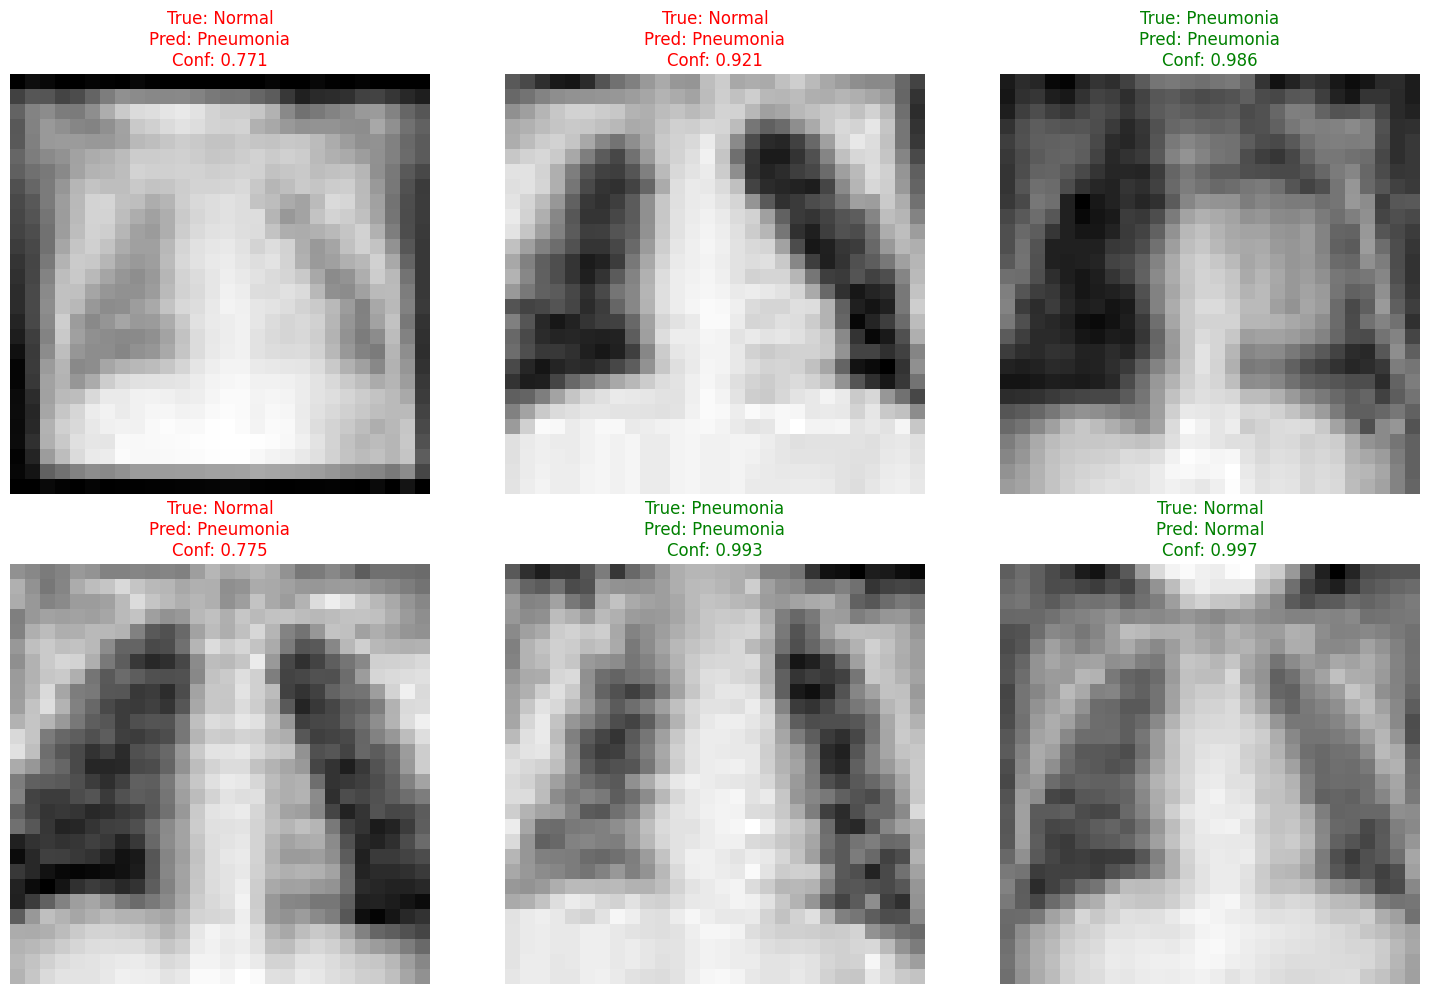

In [10]:
# Test trên một vài sample cụ thể
def test_sample_predictions(model, x_test, y_test, num_samples=6):
    """Test model on specific samples"""
    print("\nTesting on individual samples:")
    
    # Get random samples
    indices = np.random.choice(len(x_test), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        # Reshape back to image for visualization
        img = x_test[idx].reshape(28, 28)
        true_label = y_test[idx]
        pred_label = model.predict([x_test[idx]])[0]
        confidence = model.predict_proba([x_test[idx]])[0]
        
        # Labels
        true_name = 'Normal' if true_label == 0 else 'Pneumonia'
        pred_name = 'Normal' if pred_label == 0 else 'Pneumonia'
        
        # Color for correct/incorrect
        color = 'green' if true_label == pred_label else 'red'
        
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'True: {true_name}\nPred: {pred_name}\nConf: {max(confidence):.3f}', 
                          color=color)
        axes[i].axis('off')
        
        print(f"Sample {i+1}: True={true_name}, Pred={pred_name}, Confidence={max(confidence):.3f}")
    
    plt.tight_layout()
    plt.show()

# Test on sample predictions
test_sample_predictions(svm_model, x_test_final, y_test_final)

In [11]:
# Summary
print("\n" + "="*60)
print("SVM TRAINING COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"Final Model Accuracy: {accuracy:.4f}")
print(f"Total Support Vectors: {sum(svm_model.n_support_)}")
print(f"Training Samples Used: {len(x_train_final)}")
print(f"Test Samples Used: {len(x_test_final)}")
print("\nModel ready for further analysis or deployment!")


SVM TRAINING COMPLETED SUCCESSFULLY!
Final Model Accuracy: 0.8542
Total Support Vectors: 803
Training Samples Used: 4708
Test Samples Used: 624

Model ready for further analysis or deployment!
